## Transformer architectures for audio

In this course we will primarily consider transformer models and how they can be applied to audio tasks. While you don’t need to know the inner details of these models, it’s useful to understand the main concepts that make them work, so here’s a quick refresher. For a deep dive into transformers, check out our NLP Course.

How does a transformer work?

The original transformer model was designed to translate written text from one language into another. Its architecture looked like this:

![](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter1/transformers.svg)

On the left is the encoder and on the right is the decoder.

- The encoder receives an input, in this case a sequence of text tokens, and builds a representation of it (its features). This part of the model is trained to acquire understanding from the input.

- The decoder uses the encoder’s representation (the features) along with other inputs (the previously predicted tokens) to generate a target sequence. This part of the model is trained to generate outputs. In the original design, the output sequence consisted of text tokens.

There are also transformer-based models that only use the encoder part (good for tasks that require understanding of the input, such as classification), or only the decoder part (good for tasks such as text generation). An example of an encoder-only model is BERT; an example of a decoder-only model is GPT2.

A key feature of transformer models is that they are built with special layers called attention layers. These layers tell the model to pay specific attention to certain elements in the input sequence and ignore others when computing the feature representations.

### Using transformers for audio

The audio models we’ll cover in this course typically have a standard transformer architecture as shown above, but with a slight modification on the input or output side to allow for audio data instead of text. Since all these models are transformers at heart, they will have most of their architecture in common and the main differences are in how they are trained and used.

![](https://huggingface.co/datasets/huggingface-course/audio-course-images/resolve/main/transformers_blocks.png)

For audio tasks, the input and/or output sequences may be audio instead of text:

- Automatic speech recognition (ASR): The input is speech, the output is text.

- Speech synthesis (TTS): The input is text, the output is speech.

- Audio classification: The input is audio, the output is a class probability — one for each element in the sequence or a single class probability for the entire sequence.

- Voice conversion or speech enhancement: Both the input and output are audio.

There are a few different ways to handle audio so it can be used with a transformer. The main consideration is whether to use the audio in its raw form — as a waveform — or to process it as a spectrogram instead.

### Model inputs

The input to an audio model can be either text or sound. The goal is to convert this input into an embedding vector that can be processed by the transformer architecture.

**Text input**

A text-to-speech model takes text as input. This works just like the original transformer or any other NLP model: The input text is first tokenized, giving a sequence of text tokens. This sequence is sent through an input embedding layer to convert the tokens into 512-dimensional vectors. Those embedding vectors are then passed into the transformer encoder.

**Waveform input**

An automatic speech recognition model takes audio as input. To be able to use a transformer for ASR, we first need to convert the audio into a sequence of embedding vectors somehow.

Models such as **Wav2Vec2 and HuBERT use the audio waveform directly as the input to the model.** As you’ve seen in the chapter on audio data, a waveform is a one-dimensional sequence of floating-point numbers, where each number represents the sampled amplitude at a given time. **This raw waveform is first normalized to zero mean and unit variance, which helps to standardize audio samples across different volumes (amplitudes).**

![](https://huggingface.co/datasets/huggingface-course/audio-course-images/resolve/main/wav2vec2-input.png)

After normalizing, the sequence of **audio samples is turned into an embedding using a small convolutional neural network, known as the feature encoder. Each of the convolutional layers in this network processes the input sequence, subsampling the audio to reduce the sequence length, until the final convolutional layer outputs a 512-dimensional vector with the embedding for each 25 ms of audio. Once the input sequence has been transformed into a sequence of such embeddings, the transformer will process the data as usual.**

**Spectrogram input**

**One downside of using the raw waveform as input is that they tend to have long sequence lengths. For example, thirty seconds of audio at a sampling rate of 16 kHz gives an input of length 30 * 16000 = 480000. Longer sequence lengths require more computations in the transformer model, and so higher memory usage.**

Because of this, raw audio waveforms are not usually the most efficient form of representing an audio input. **By using a spectrogram, we get the same amount of information but in a more compressed form.**

![](https://huggingface.co/datasets/huggingface-course/audio-course-images/resolve/main/whisper-input.png)

**Models such as Whisper first convert the waveform into a log-mel spectrogram. Whisper always splits the audio into 30-second segments, and the log-mel spectrogram for each segment has shape (80, 3000) where 80 is the number of mel bins and 3000 is the sequence length.** By converting to a log-mel spectrogram we’ve reduced the amount of input data, but more importantly, this is a much shorter sequence than the raw waveform. The log-mel spectrogram is then processed by a small CNN into a sequence of embeddings, which goes into the transformer as usual.

In both cases, waveform as well as spectrogram input, there is a small network in front of the transformer that converts the input into embeddings and then the transformer takes over to do its thing.

### Model outputs

The transformer architecture outputs a sequence of hidden-state vectors, also known as the output embeddings. Our goal is to transform these vectors into a text or audio output.

**Text output**

The goal of an automatic speech recognition model is to predict a sequence of text tokens. This is done by adding a language modeling head — typically a single linear layer — followed by a softmax on top of the transformer’s output. This predicts the probabilities over the text tokens in the vocabulary.

**Spectrogram output**

For models that generate audio, such as a text-to-speech (TTS) model, we’ll have to add layers that can produce an audio sequence. **It’s very common to generate a spectrogram and then use an additional neural network, known as a vocoder, to turn this spectrogram into a waveform.**

**In the SpeechT5 TTS model, for example, the output from the transformer network is a sequence of 768-element vectors. A linear layer projects that sequence into a log-mel spectrogram. A so-called post-net, made up of additional linear and convolutional layers, refines the spectrogram by reducing noise. The vocoder then makes the final audio waveform.**

![](https://huggingface.co/datasets/huggingface-course/audio-course-images/resolve/main/speecht5.png)

> 💡 If you take an existing waveform and apply the Short-Time Fourier Transform or STFT, it is possible to perform the inverse operation, the ISTFT, to get the original waveform again. This works because the spectrogram created by the STFT contains both amplitude and phase information, and both are needed to reconstruct the waveform. However, audio models that generate their output as a spectrogram typically only predict the amplitude information, not the phase. To turn such a spectrogram into a waveform, we have to somehow estimate the phase information. That's what a vocoder does.

**Waveform output**

It’s also possible for models to directly output a waveform instead of a spectrogram as an intermediate step, but we currently don’t have any models in 🤗 Transformers that do this.

**Conclusion**

In summary: Most audio transformer models are more alike than different — they’re all built on the same transformer architecture and attention layers, although some models will only use the encoder portion of the transformer while others use both the encoder and decoder.

You’ve also seen how to get audio data into and out of transformer models. To perform the different audio tasks of ASR, TTS, and so on, we can simply swap out the layers that pre-process the inputs into embeddings, and swap out the layers that post-process the predicted embeddings into outputs, while the transformer backbone stays the same.

Next, let’s look at a few different ways these models can be trained to do automatic speech recognition.

## CTC architectures

**CTC or Connectionist Temporal Classification is a technique that is used with encoder-only transformer models for automatic speech recognition. Examples of such models are Wav2Vec2, HuBERT and M-CTC-T.**

An encoder-only transformer is the simplest kind of transformer because it just uses the encoder portion of the model. The encoder reads the input sequence (the audio waveform) and maps this into a sequence of hidden-states, also known as the output embeddings.

With a CTC model, we apply an additional linear mapping on the sequence of hidden-states to get class label predictions. The class labels are the characters of the alphabet (a, b, c, …). This way we’re able to predict any word in the target language with a small classification head, as the vocabulary just needs to exist of 26 characters plus a few special tokens.

![](https://huggingface.co/datasets/huggingface-course/audio-course-images/resolve/main/wav2vec2-ctc.png)

So far, this is very similar to what we do in NLP with a model such as BERT: an encoder-only transformer model maps our text tokens into a sequence of encoder hidden-states, and then we apply a linear mapping to get one class label prediction for each hidden-state.

Here’s the rub: In speech, we don’t know the alignment of the audio inputs and text outputs. We know that the order the speech is spoken in is the same as the order that the text is transcribed in (the alignment is so-called monotonic), but we don’t know how the characters in the transcription line up to the audio. This is where the CTC algorithm comes in.

> 💡 **In NLP models the vocabulary is usually made up of thousands of tokens that describe not just individual characters but parts of words or even complete words. For CTC, however, a small vocabulary works best and we generally try to keep it to less than 50 characters. We don't care about the casing of the letters, so only using uppercase (or only lowercase) is sufficient. Numbers are spelled out, e.g. `"20"` becomes `"twenty"`. In addition to the letters, we need at least a word separator token (space) and a padding token. Just as with an NLP model, the padding token allows us to combine multiple examples in a batch, but it's also the token the model will predict for silences. In English, it's also useful to keep the `'` character — after all, `"it's"` and `"its"` have very different meanings.**

### Dude, where’s my alignment?

Automatic speech recognition or ASR involves taking audio as input and producing text as output. We have a few choices for how to predict the text:

- as individual characters
- as phonemes
- as word tokens

An ASR model is trained on a dataset consisting of (audio, text) pairs where the text is a human-made transcription of the audio file. Generally the dataset does not include any timing information that says which word or syllable occurs where in the audio file. Since we can’t rely on timing information during training, we don’t have any idea how the input and output sequences should be aligned.

**Let’s suppose our input is a one-second audio file. In Wav2Vec2, the model first downsamples the audio input using the CNN feature encoder to a shorter sequence of hidden-states, where there is one hidden-state vector for every 20 milliseconds of audio. For one second of audio, we then forward a sequence of 50 hidden-states to the transformer encoder. (The audio segments extracted from the input sequence partially overlap, so even though one hidden-state vector is emitted every 20 ms, each hidden-state actually represent 25 ms of audio.)**

The transformer encoder predicts one feature representation for each of these hidden-states, meaning we receive a sequence of 50 outputs from the transformer. Each of these outputs has a dimensionality of 768. The output sequence of the transformer encoder in this example therefore has shape (768, 50). As each of these predictions covers 25 ms of time, which is shorter than the duration of a phoneme, it makes sense to predict individual phonemes or characters but not entire words. CTC works best with a small vocabulary, so we’ll predict characters.


![](https://huggingface.co/datasets/huggingface-course/audio-course-images/resolve/main/cnn-feature-encoder.png)

To make text predictions, we map each of the 768-dimensional encoder outputs to our character labels using a linear layer (the “CTC head”). The model then predicts a (50, 32) tensor containing the logits, where 32 is the number of tokens in the vocabulary. Since we make one prediction for each of the features in the sequence, we end up with a total of 50 character predictions for each second of audio.

**However, if we simply predict one character every 20 ms, our output sequence might look something like this:**

```
BRIIONSAWWSOMEETHINGCLOSETOPANICONHHISOPPONENT'SSFAACEWHENTHEMANNFINALLLYRREECOGGNNIIZEDHHISSERRRRORR ..`
```

**If you look closely, it somewhat resembles English but a lot of the characters have been duplicated. That’s because the model needs to output something for every 20 ms of audio in the input sequence, and if a character is spread out over a period longer than 20 ms then it will appear multiple times in the output.** There’s *no way to avoid* this, especially since we don’t know what the timing of the transcript is during training. CTC is a way to filter out these duplicates.

(In reality, the predicted sequence also contains a lot of padding tokens for when the model isn’t quite sure what the sound represents, or for the empty space between characters. We removed these padding tokens from the example for clarity. The partial overlap between audio segments is another reason characters get duplicated in the output.)

### The CTC algorithm

The key to the CTC algorithm is using a special token, often called the blank token. This is just another token that the model will predict and it’s part of the vocabulary. In this example, the blank token is shown as _. This special token serves as a hard boundary between groups of characters.

The full output from the CTC model might be something like the following:

```
B_R_II_O_N_||_S_AWW_|||||_S_OMEE_TH_ING_||_C_L_O_S_E||TO|_P_A_N_I_C_||_ON||HHI_S||_OP_P_O_N_EN_T_'SS||_F_AA_C_E||_W_H_EN||THE||M_A_NN_||||_F_I_N_AL_LL_Y||||_RREE_C_O_GG_NN_II_Z_ED|||HHISS|||_ER_RRR_ORR||||
```

The | token is the word separator character. In the example we use | instead of a space making it easier to spot where the word breaks are, but it serves the same purpose.

The CTC blank character makes it possible to filter out the duplicate characters. For example let’s look at the last word from the predicted sequence, _ER_RRR_ORR. Without the CTC blank token, the word looked like this:

```
ERRRRORR
```

If we were to simply remove duplicate characters, this would become EROR. That’s clearly not the correct spelling. But with the CTC blank token we can remove the duplicates in each group, so that:

```
_ER_RRR_OR
```

becomes:

```
_ER_R_OR
```

and now we remove the _ blank token to get the final word:

```
ERROR
```

If we apply this logic to the entire text, including |, and replace the surviving | characters by spaces, the final CTC-decoded output is:

```
BRION SAW SOMETHING CLOSE TO PANIC ON HIS OPPONENT'S FACE WHEN THE MAN FINALLY RECOGNIZED HIS ERROR
```

**To recap, the model predicts one token (character) for every 20 ms of (partially overlapping) audio from the input waveform. This gives a lot of duplicates. Thanks to the CTC blank token, we can easily remove these duplicates without destroying the proper spelling of the words. This is a very simple and convenient way to solve the problem of aligning the output text with the input audio.**

> 💡 In the actual Wav2Vec2 model, the CTC blank token is the same as the padding token ``. The model will predict many of these `` tokens, for example when there isn't a clear character to predict for the current 20 ms of audio. Using the same token for padding as for CTC blanking simplifies the decoding algorithm and it helps keep the vocab small.

Adding CTC to a transformer encoder model is easy: the output sequence from the encoder goes into a linear layer that projects the acoustic features to the vocabulary. The model is trained with a special CTC loss.

**One downside of CTC is that it may output words that sound correct, but are not spelled correctly.** After all, the CTC head only considers individual characters, not complete words. One way to improve the quality of the audio transcriptions is to use an external language model. This language model essentially acts as a spellchecker on top of the CTC output.

### What’s the difference between Wav2Vec2, HuBERT, M-CTC-T, …?

All transformer-based CTC models have a very similar architecture: they use the transformer encoder (but not the decoder) with a CTC head on top. Architecture-wise they are more alike than different.

One difference between Wav2Vec2 and M-CTC-T is that the former works on raw audio waveforms while the latter uses mel spectrograms as input. The models also have been trained for different purposes. M-CTC-T, for example, is trained for multilingual speech recognition, and therefore has a relatively large CTC head that includes Chinese characters in addition to other alphabets.

**Wav2Vec2 & HuBERT use the exact same architecture but are trained in very different ways. Wav2Vec2 is pre-trained like BERT’s masked language modeling, by predicting speech units for masked parts of the audio. HuBERT takes the BERT inspiration a step further and learns to predict “discrete speech units”, which are analogous to tokens in a text sentence, so that speech can be treated using established NLP techniques.**

To clarify, the models highlighted here aren’t the only transformer-based CTC models. There are many others, but now you know they all work in a similar way.

## Seq2Seq architectures

The CTC models discussed in the previous section used only the encoder part of the transformer architecture. When we also add the decoder to create an encoder-decoder model, this is referred to as a sequence-to-sequence model or seq2seq for short. The model maps a sequence of one kind of data to a sequence of another kind of data.

With encoder-only transformer models, the encoder made a prediction for each element in the input sequence. Therefore, both input and output sequences will always have the same length. In the case of CTC models such as Wav2Vec2 the input waveform was first downsampled, but there still was one prediction for every 20 ms of audio.

With a seq2seq model, there is no such one-to-one correspondence and the input and output sequences can have different lengths. That makes seq2seq models suitable for NLP tasks such as text summarization or translation between different languages — but also for audio tasks such as speech recognition.

The architecture of a decoder is very similar to that of an encoder, and both use similar layers with self-attention as the main feature. However, the decoder performs a different task than the encoder. To see how this works, let’s examine how a seq2seq model can do automatic speech recognition.

Automatic speech recognition

The architecture of Whisper is as follows figure courtesy of [OpenAI Whisper blog](https://openai.com/index/whisper/):

![](https://huggingface.co/blog/assets/111_fine_tune_whisper/whisper_architecture.svg)

This should look quite familiar. On the left is the transformer encoder. This takes as input a log-mel spectrogram and encodes that spectrogram to form a sequence of encoder hidden states that extract important features from the spoken speech. This hidden-states tensor represents the input sequence as a whole and effectively encodes the “meaning” of the input speech.

> 💡 It's common for these seq2seq models to use spectrograms as input. However, a seq2seq model can also be designed to work directly on audio waveforms.
The output of the encoder is then passed into the transformer decoder, shown on the right, using a mechanism called cross-attention. This is like self-attention but attends over the encoder output. From this point on, the encoder is no longer needed.

The decoder predicts a sequence of text tokens in an autoregressive manner, a single token at a time, starting from an initial sequence that just has a “start” token in it (SOT in the case of Whisper). At each following timestep, the previous output sequence is fed back into the decoder as the new input sequence. In this manner, the decoder emits one new token at a time, steadily growing the output sequence, until it predicts an “end” token or a maximum number of timesteps is reached.

While the architecture of the decoder is mostly identical to that of the encoder, there are two big differences:

1. the decoder has a cross-attention mechanism that allows it to look at the encoder’s representation of the input sequence
2. the decoder’s attention is causal — the decoder isn’t allowed to look into the future.

In this design, the decoder plays the role of a language model, processing the hidden-state representations from the encoder and generating the corresponding text transcriptions. This is a more powerful approach than CTC, even if the CTC model is combined with an external language model, as the seq2seq system can be trained end-to-end with the same training data and loss function, giving greater flexibility and generally superior performance.

> 💡 Whereas a CTC model outputs a sequence of individual characters, the tokens predicted by Whisper are full words or portions of words. It uses the tokenizer from GPT-2 and has 50k+ unique tokens. A seq2seq model can therefore output a much shorter sequence than a CTC model for the same transcription.

**A typical loss function for a seq2seq ASR model is the cross-entropy loss, as the final layer of the model predicts a probability distribution over the possible tokens. This is usually combined with techniques such as beam search to generate the final sequence. The metric for speech recognition is WER or word error rate, which measures how many substitutions, insertions, and deletions are necessary to turn the predicted text into the target text — the fewer, the better the score.**

### Text-to-speech

It may not surprise you: A seq2seq model for TTS works essentially the same as described above but with the inputs and outputs switched around! The transformer encoder takes in a sequence of text tokens and extracts a sequence of hidden-states that represent the input text. The transformer decoder applies cross-attention to the encoder output and predicts a spectrogram.

> 💡 Recall that a spectrogram is made by taking the frequency spectrum of successive time slices of an audio waveform and stacking them together. In other words, a spectrogram is a sequence where the elements are (log-mel) frequency spectra, one for each timestep.

With the ASR model, the decoder was kickstarted using a sequence that just has the special “start” token in it. For the TTS model, we can start the decoding with a spectrogram of length one that is all zeros that acts as the “start token”. Given this initial spectrogram and the cross-attentions over the encoder’s hidden-state representations, the decoder then predicts the next timeslice for this spectrogram, steadily growing the spectrogram one timestep at a time.

![](https://huggingface.co/datasets/huggingface-course/audio-course-images/resolve/main/speecht5_decoding.png)

But how does the decoder know when to stop? In the SpeechT5 model this is handled by making the decoder predict a second sequence. **This contains the probability that the current timestep is the last one. While generating audio at inference time, if this probability is over a certain threshold (say 0.5), the decoder is indicating that the spectrogram is finished and the generation loop should end.**

After the decoding finishes and we have an output sequence containing the spectrogram, SpeechT5 uses a so-called post-net that is made up of several convolution layers to refine the spectrogram.

During training of the TTS model, the targets are also spectrograms and the loss is L1 or MSE. At inference time we want to convert the output spectrogram into an audio waveform, so that we can actually listen to it. For this an external model is used, the vocoder. **This vocoder is not part of the seq2seq architecture and is trained separately.**

What makes TTS difficult is that it’s a one-to-many mapping. With speech-to-text there is only one correct output text that corresponds to the input speech, but with text-to-speech the input text can be mapped to many possible speech sounds. Different speakers may choose to emphasize different parts of the sentence, for example. This makes TTS models hard to evaluate. Because of this, the L1 or MSE loss value isn’t actually very meaningful — there are multiple ways to represent the same text to a spectrogram. **This is why TTS models are typically evaluated by human listeners, using a metric known as MOS or mean opinion score.**

**Conclusion**

The seq2seq approach is more powerful than an encoder-only model. By separating the encoding of the input sequence from the decoding of the output sequence, the alignment of audio and text is less of a problem.

However, an encoder-decoder model is also slower as the decoding process happens one step at a time, rather than all at once. The longer the sequence, the slower the prediction. Autoregressive models can also get stuck in repetitions or skip words. Techniques such as beam search can help improve the quality of the predictions, but also slow down decoding even more.

## Audio classification architectures

The goal of audio classification is to predict a class label for an audio input. The model can predict a single class label that covers the entire input sequence, or it can predict a label for every audio frame — typically every 20 milliseconds of input audio — in which case the model’s output is a sequence of class label probabilities. An example of the former is detecting what bird is making a particular sound; an example of the latter is **speaker diarization, where the model predicts which speaker is speaking at any given moment.**

### Classification using spectrograms

One of the easiest ways to perform audio classification is to pretend it’s an image classification problem!

Recall that a **spectrogram is a two-dimensional tensor of shape (frequencies, sequence length).** In the chapter on audio data we plotted these spectrograms as images. Guess what? We can literally treat the spectrogram as an image and pass it into a regular CNN classifier model such as ResNet and get very good predictions. Even better, we can use a image transformer model such as ViT.

This is what A**udio Spectrogram Transformer** does. It uses the ViT or Vision Transformer model, and passes it spectrograms as input instead of regular images. Thanks to the transformer’s self-attention layers, the model is better able to capture global context than a CNN is.

Just like ViT, the AST model splits the audio spectrogram into a sequence of partially overlapping image patches of 16×16 pixels. This sequence of patches is then projected into a sequence of embeddings, and these are given to the transformer encoder as input as usual. AST is an encoder-only transformer model and so the output is a sequence of hidden-states, one for each 16×16 input patch. On top of this is a simple classification layer with sigmoid activation to map the hidden-states to classification probabilities.

![](https://huggingface.co/datasets/huggingface-course/audio-course-images/resolve/main/ast.png)

Image from the paper AST: [Audio Spectrogram Transformer](https://arxiv.org/pdf/2104.01778)

> 💡 Even though here we pretend spectrograms are the same as images, there are important differences. For example, shifting the contents of an image up or down generally does not change the meaning of what is in the image. However, shifting a spectrogram up or down will change the frequencies that are in the sound and completely change its character. Images are invariant under translation but spectrograms are not. Treating spectrograms as images can work very well in practice, but keep in mind they are not really the same thing.

### Any transformer can be a classifier

In a previous section you’ve seen that CTC is an efficient technique for performing automatic speech recognition using an encoder-only transformer. Such CTC models already are classifiers, predicting probabilities for class labels from a tokenizer vocabulary. We can take a CTC model and turn it into a general-purpose audio classifier by changing the labels and training it with a regular cross-entropy loss function instead of the special CTC loss.

**For example, HF Transformers has a Wav2Vec2ForCTC model but also Wav2Vec2ForSequenceClassification and Wav2Vec2ForAudioFrameClassification. The only differences between the architectures of these models is the size of the classification layer and the loss function used.**

In fact, any encoder-only audio transformer model can be turned into an audio classifier by adding a classification layer on top of the sequence of hidden states. (Classifiers usually don’t need a transformer decoder.)

**To predict a single classification score for the entire sequence (Wav2Vec2ForSequenceClassification), the model takes the mean over the hidden-states and feeds that into the classification layer. The output is a single probability distribution.**

**To make a separate classification for each audio frame (Wav2Vec2ForAudioFrameClassification), the classifier is run on the sequence of hidden-states, and so the output of the classifier is a sequence too.**

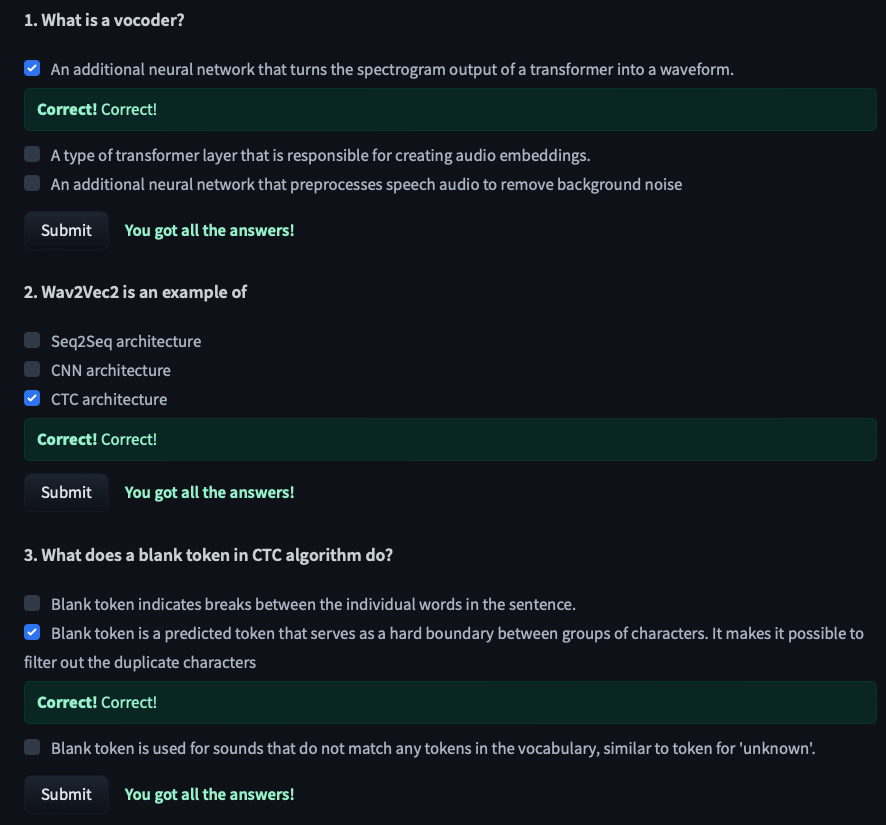

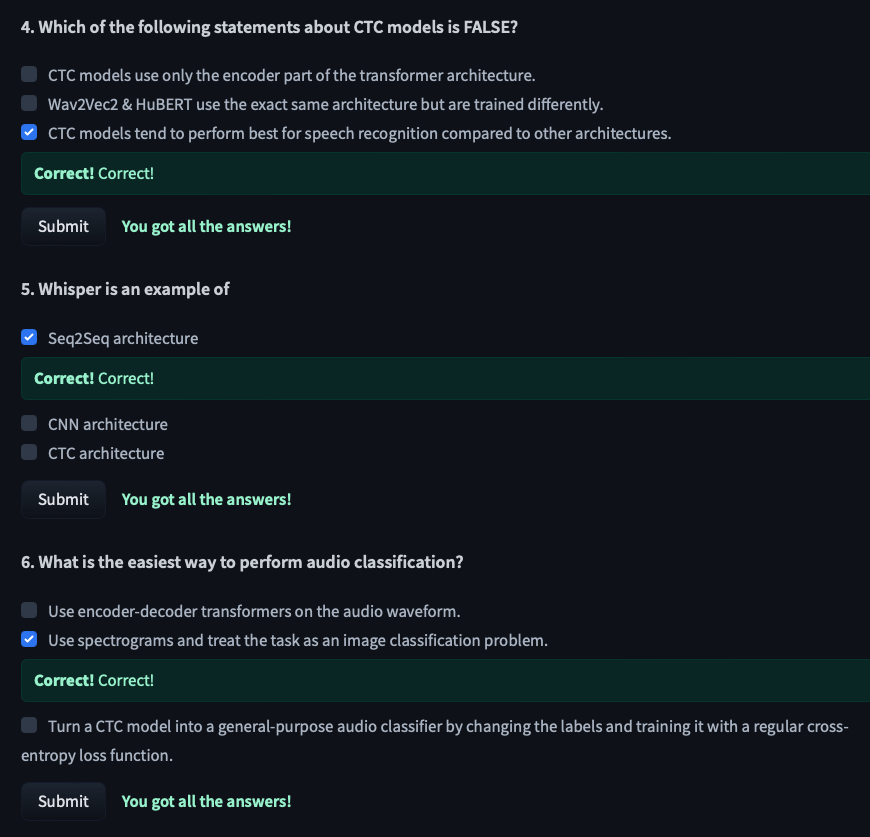



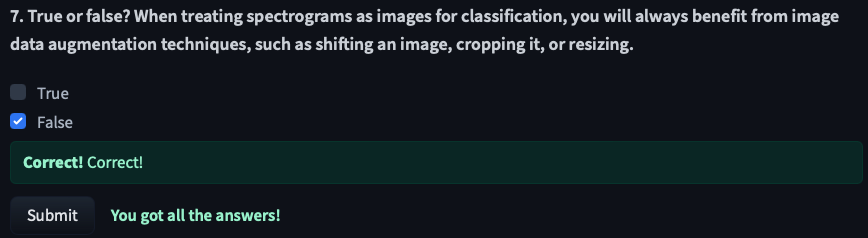

# Supplemental reading and resources

If you’d like to further explore different Transformer architectures, and learn about their various applications in speech processing, check out this recent paper:

### Transformers in Speech Processing: A Survey

by Siddique Latif, Aun Zaidi, Heriberto Cuayahuitl, Fahad Shamshad, Moazzam Shoukat, Junaid Qadir

“The remarkable success of transformers in the field of natural language processing has sparked the interest of the speech-processing community, leading to an exploration of their potential for modeling long-range dependencies within speech sequences. Recently, transformers have gained prominence across various speech-related domains, including automatic speech recognition, speech synthesis, speech translation, speech para-linguistics, speech enhancement, s poken dialogue systems, and numerous multimodal applications. In this paper, we present a comprehensive survey that aims to bridge research studies from diverse subfields within speech technology. By consolidating findings from across the speech technology landscape, we provide a valuable resource for researchers interested in harnessing the power of transformers to advance the field. We identify the challenges encountered by transformers in speech processing while also offering insights into potential solutions to address these issues.”

https://arxiv.org/abs/2303.11607